##**Imports**

In [ ]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.4
    Uninstalling keras-3.0.4:
      Successfully uninstalled keras-3.0.4


In [ ]:
!nvidia-smi

Wed Feb  7 08:39:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## **Utility Functions**

In [ ]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

##**Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 1 and 2 (otherwise skip Step 0 and go to Step 1)**

In [ ]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1_difVXO-_N1iMFzxMP2IFeD7e8tUhRBV'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './data/processed'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()



Creating folder: ./data/processed/bag
Creating folder: ./data/processed/bag/val_dataset
Creating folder: ./data/processed/bag/val_dataset/7094108079719339233
Creating folder: ./data/processed/bag/val_dataset/7094108079719339233/00000000.shard
Creating folder: ./data/processed/bag/test_dataset
Creating folder: ./data/processed/bag/test_dataset/10708988183537814467
Creating folder: ./data/processed/bag/test_dataset/10708988183537814467/00000000.shard
Creating folder: ./data/processed/bag/train_dataset
Creating folder: ./data/processed/bag/train_dataset/13562169807097260504
Creating folder: ./data/processed/bag/train_dataset/13562169807097260504/00000000.shard
Creating folder: ./data/processed/clothes_new
Creating folder: ./data/processed/clothes_new/test_dataset
Creating folder: ./data/processed/clothes_new/test_dataset/14824926411023993334
Creating folder: ./data/processed/clothes_new/test_dataset/14824926411023993334/00000000.shard
Creating folder: ./data/processed/clothes_new/val_data

In [ ]:
PRODUCT_CATEGORY = 'clothes'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_SIZE = (427, 350)
IMG_SHAPE = (427, 350, 3)
BATCH_SIZE = 32
CLASSES = ['clothes_0_model_front'
           , 'clothes_1_zoomed'
           , 'clothes_2_model_back'
           , 'clothes_3_ghost'
           , 'clothes_4_look'
           ]

train_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/train_dataset')
val_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/val_dataset')
test_ds = tf.data.experimental.load(f'./data/processed/{PRODUCT_CATEGORY}/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [ ]:
def df_from_json(json_path, image_path):
  tdf = pd.read_json(json_path, orient='index')
  tdf['image_name'] = tdf['image_path'] + '/' + tdf['image_name']
  tdf['species'] = tdf['genus'] + '_' + tdf['specific_epithet']

  image_path = os.path.join(image_path, '')
  list_image_paths = glob.glob(image_path+'*/*.JPG')
  list_image_paths = [x.replace(image_path,'') for x in list_image_paths]
  check_image_bool = tdf['image_name'].apply(lambda x: x in list_image_paths)
  tdf = tdf[check_image_bool]

  print('loaded {}.json with shape {}'.format(json_path, tdf.shape))
  return tdf

In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
clothes_0_model_front occurs 171 times
clothes_1_zoomed occurs 187 times
clothes_2_model_back occurs 145 times
clothes_3_ghost occurs 140 times
clothes_4_look occurs 125 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
clothes_0_model_front occurs 58 times
clothes_1_zoomed occurs 52 times
clothes_2_model_back occurs 54 times
clothes_3_ghost occurs 46 times
clothes_4_look occurs 46 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
clothes_0_model_front occurs 51 times
clothes_1_zoomed occurs 58 times
clothes_2_model_back occurs 46 times
clothes_3_ghost occurs 43 times
clothes_4_look occurs 49 times


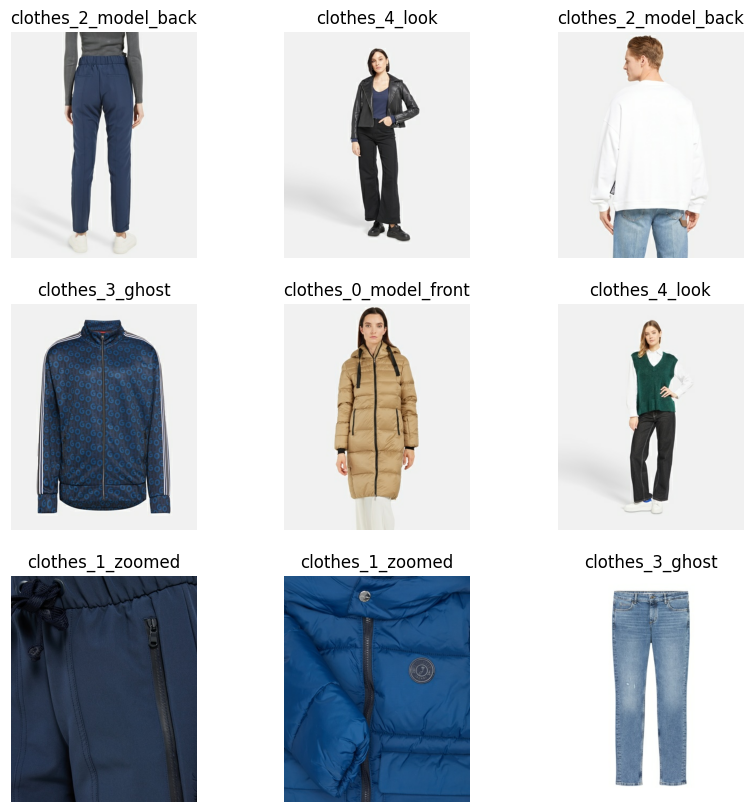

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")


## **Step 1: Importing the Image data from Google drive**

**Note:** we figured out how to download a nested folder structure allong with the files from Google Drive (instead of just one file) from the following StackOverflow discussion - https://stackoverflow.com/questions/46155300/pydrive-error-no-downloadlink-exportlinks-for-mimetype-found-in-metadata

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac'
# Note: these folders should match the final project folder structure we create and may need to be updated
root = './data/raw'
# If the folders that we want to download the images to do not exit then create them as shown below:
os.mkdir('./data')
os.mkdir('./data/raw')

search_folder(folder_id,root+'/')
f.close()

Creating folder: ./data/raw/waesche
Creating folder: ./data/raw/waesche/waesche_2_model_back
Creating folder: ./data/raw/schuhe
Creating folder: ./data/raw/schuhe/schuhe_4_zoom
Creating folder: ./data/raw/schuhe/schuhe_0_overall_to_right
Creating folder: ./data/raw/waesche/waesche_1_zoomed
Creating folder: ./data/raw/schuhe/schuhe_1_back
Creating folder: ./data/raw/schuhe/schuhe_3_side_to_left
Creating folder: ./data/raw/waesche/waesche_0_model_front
Creating folder: ./data/raw/waesche/waesche_3_ghost
Creating folder: ./data/raw/waesche/waesche_4_look
Creating folder: ./data/raw/schuhe/schuhe_2_top_or_soul
Creating folder: ./data/raw/clothes
Creating folder: ./data/raw/clothes/clothes_3_ghost
Creating folder: ./data/raw/clothes/clothes_0_model_front
Creating folder: ./data/raw/clothes/clothes_1_zoomed
Creating folder: ./data/raw/bag
Creating folder: ./data/raw/bag/bag_1_side
Creating folder: ./data/raw/clothes/clothes_4_look
Creating folder: ./data/raw/clothes/clothes_2_model_back
Crea

##**Step 2: Load image data and split them into Train, Validation and Test**

### **Step 2.1: Process the data from Step 1:**

**Note:** there is a script we can run to find corrupted images. We ran this script and found an image (./image_data/raw/clothes/clothes_1_zoomed/32760559-001.jpg') that was corrupted and deleted it from the directory so it does not cause issues down stream when we train our models

In [ ]:
import pathlib
root = './data/raw'
data_dir = pathlib.Path(root)
data_dir

PosixPath('data/raw')

In [ ]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (791 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121730 files and directories currently install

In [ ]:
!tree --dirsfirst --filelimit 6 './data/raw'

./data/raw
├── bag
│   ├── bag_0_front  [31 entries exceeds filelimit, not opening dir]
│   ├── bag_1_side  [25 entries exceeds filelimit, not opening dir]
│   ├── bag_2_inside  [19 entries exceeds filelimit, not opening dir]
│   ├── bag_3_back  [26 entries exceeds filelimit, not opening dir]
│   └── bag_4_look  [23 entries exceeds filelimit, not opening dir]
├── clothes
│   ├── clothes_0_model_front  [279 entries exceeds filelimit, not opening dir]
│   ├── clothes_1_zoomed  [287 entries exceeds filelimit, not opening dir]
│   ├── clothes_2_model_back  [247 entries exceeds filelimit, not opening dir]
│   ├── clothes_3_ghost  [236 entries exceeds filelimit, not opening dir]
│   └── clothes_4_look  [223 entries exceeds filelimit, not opening dir]
├── schuhe
│   ├── schuhe_0_overall_to_right  [92 entries exceeds filelimit, not opening dir]
│   ├── schuhe_1_back  [87 entries exceeds filelimit, not opening dir]
│   ├── schuhe_2_top_or_soul  [91 entries exceeds filelimit, not opening dir]
│ 

In [ ]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 1913


In [ ]:
clothes_0_model_front = list(data_dir.glob('clothes/clothes_0_model_front/*.jpg'))

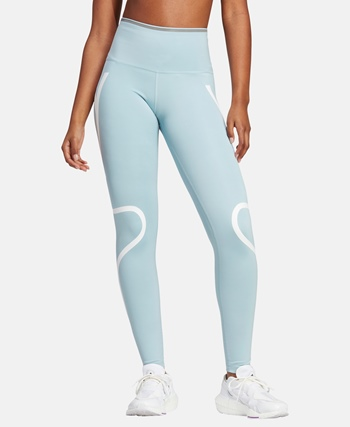

In [ ]:
PIL.Image.open(str(clothes_0_model_front[4]))

**The script above found one corrupted image in the clothes_1_zoomed folder - './data/raw/clothes/clothes_1_zoomed/32760559-001.jpg'**

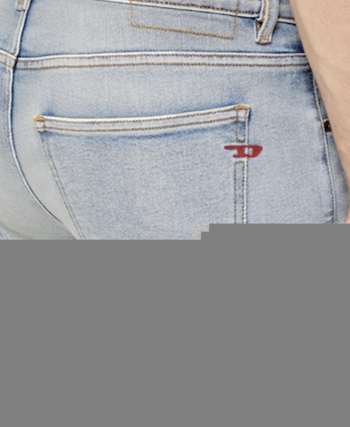

In [ ]:
from struct import unpack
from tqdm import tqdm
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                raise TypeError("issue reading jpeg file")

bads = []

img_dir = root

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
        image = os.path.join(dirName,img)
        image = JPEG(image)
        try:
            image.decode()
        except:
            bads.append(dirName+'/'+img)

#Show the bad images
bads

#remove the bad images
# note: we found the following image that was corrupted that we removed - ./raw/clothes/clothes_1_zoomed/32760559-001.jpg'
# for name in bads:
#   os.remove(name)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 87/87 [00:00<00:00, 22704.36it/s]
0it [00:00, ?it/s]
100%|██████████| 236/236 [00:00<00:00, 23716.50it/s]
0it [00:00, ?it/s]
100%|██████████| 26/26 [00:00<00:00, 13197.62it/s]
0it [00:00, ?it/s]
100%|██████████| 23/23 [00:00<00:00, 14981.98it/s]


['./data/raw/clothes/clothes_1_zoomed/32760559-001.jpg']

In [ ]:
bads

['./data/raw/clothes/clothes_1_zoomed/32760559-001.jpg']

In [ ]:
# Delete the corrupted image from the folder
for name in bads:
  os.remove(name)

In [ ]:
# Image count after deleting the corrupted image
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 1912


###**Step 2.1: Split data into Train, Validatin and Test**

In [ ]:
RANDOM_SEED = 42
#VAL_SPLIT = 0.4
PRODUCT_CATEGORY = 'clothes'
BATCH_SIZE = 32
IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
SHUFFLE = True

PROD_DATA_DIR = pathlib.Path(root+'/'+PRODUCT_CATEGORY)
CLASSES = ['clothes_0_model_front'
           , 'clothes_1_zoomed'
           , 'clothes_2_model_back'
           , 'clothes_3_ghost'
           , 'clothes_4_look'
           ]

# This code gives the classes
# for item in os.scandir(PROD_DATA_DIR):
#     if not item.name.startswith('.'): #dont include any hidden files or dirs that may be in the folder (more applicable when running on local machine)
#         CLASSES.append(item.name)

In [ ]:
CLASSES

['clothes_0_model_front',
 'clothes_1_zoomed',
 'clothes_2_model_back',
 'clothes_3_ghost',
 'clothes_4_look']

In [ ]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = PROD_DATA_DIR,
  seed=RANDOM_SEED,
  class_names=CLASSES,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = SHUFFLE)

ds_batches = tf.data.experimental.cardinality(full_ds)
train_ds = full_ds.take(((ds_batches) * 3) // 5) #60% of the data for training
val_test_ds = full_ds.skip(((ds_batches) * 3) // 5) #40% of the remaining data for validation and test

val_test_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take((val_test_batches) // 2) #50% of the val_test_ds for validation (20% of full_ds)
test_ds = val_test_ds.skip((val_test_batches) // 2) #50% of the val_test_ds for Test (20% of full_ds)

print(f'Train data size = {len(train_ds)*BATCH_SIZE}')
print(f'Validation data size = {len(val_ds)*BATCH_SIZE}')
print(f'Test data size = {len(test_ds)*BATCH_SIZE}')

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   directory = PROD_DATA_DIR,
#   validation_split=VAL_SPLIT,
#   subset="validation",
#   seed=RANDOM_SEED,
#   class_names=CLASSES,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE,
#   shuffle = SHUFFLE)

Found 1271 files belonging to 5 classes.
Train data size = 768
Validation data size = 256
Test data size = 256


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
clothes_0_model_front occurs 171 times
clothes_1_zoomed occurs 187 times
clothes_2_model_back occurs 145 times
clothes_3_ghost occurs 140 times
clothes_4_look occurs 125 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
clothes_0_model_front occurs 58 times
clothes_1_zoomed occurs 52 times
clothes_2_model_back occurs 54 times
clothes_3_ghost occurs 46 times
clothes_4_look occurs 46 times


In [ ]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
clothes_0_model_front occurs 51 times
clothes_1_zoomed occurs 58 times
clothes_2_model_back occurs 46 times
clothes_3_ghost occurs 43 times
clothes_4_look occurs 49 times


###**Step 2.3: Save the Train, Val and Test tensor datasets so it can saved in a Google Drive to be used later. That way we dont have to download all images again and it is muh faster to train a new model with the same data (refer to Step 0)**

In [ ]:
os.mkdir('./data/processed')
os.mkdir('./data/processed/clothes')
tf.data.experimental.save(train_ds, './data/processed/clothes/train_dataset')
tf.data.experimental.save(val_ds, './data/processed/clothes/val_dataset')
tf.data.experimental.save(test_ds, './data/processed/clothes/test_dataset')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


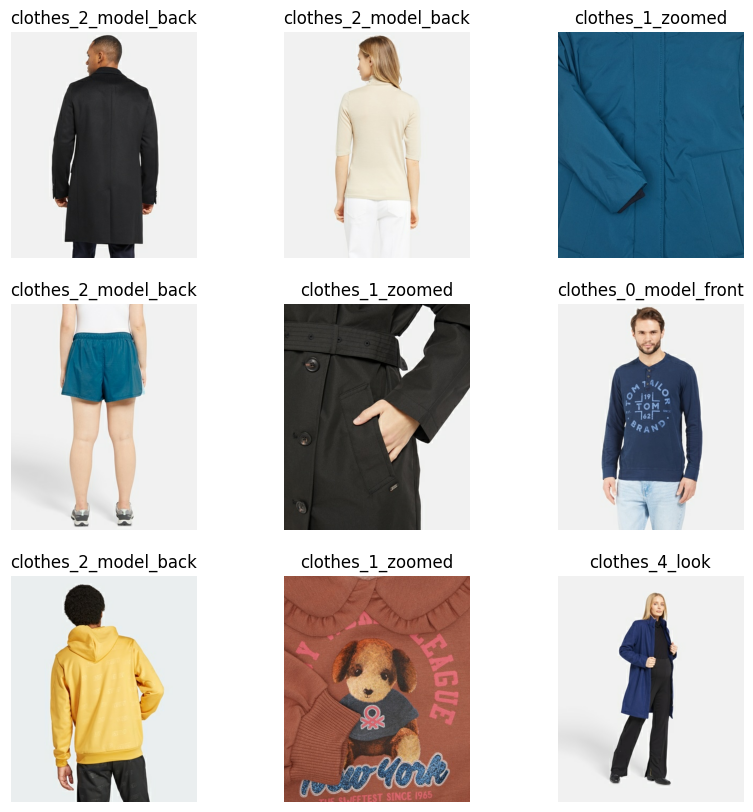

In [ ]:
# Check that the label and images match
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

## **Step 3: Create and train the base CNN model**

In [ ]:
# The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def create_base_model():
    model = keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),

      tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(256, activation='relu'),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
model_CNNbase = create_base_model()
model_CNNbase.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model_CNNbase.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 427, 350, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 427, 350, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 213, 175, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 175, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 106, 87, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 106, 87, 128)      7

## Train the model

In [ ]:
history_base = model_CNNbase.fit(
    x=train_ds,
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose="auto",
    # callbacks=None,
    # validation_split=0.3,
    # shuffle=True,
    validation_data=val_ds
    # class_weight=None,
    # sample_weight=None,
    # initial_epoch=0,
    # steps_per_epoch=None,
    # validation_steps=None,
    # validation_batch_size=None,
    # validation_freq=1,
)

Epoch 1/10
24/24 [==============================] - 15s 220ms/step - loss: 1.5061 - accuracy: 0.4193 - val_loss: 1.0260 - val_accuracy: 0.5586
Epoch 2/10
24/24 [==============================] - 4s 166ms/step - loss: 0.7260 - accuracy: 0.7096 - val_loss: 0.5536 - val_accuracy: 0.7734
Epoch 3/10
24/24 [==============================] - 4s 168ms/step - loss: 0.4738 - accuracy: 0.8034 - val_loss: 0.4747 - val_accuracy: 0.8008
Epoch 4/10
24/24 [==============================] - 4s 167ms/step - loss: 0.3413 - accuracy: 0.8568 - val_loss: 0.3759 - val_accuracy: 0.8828
Epoch 5/10
24/24 [==============================] - 4s 169ms/step - loss: 0.2312 - accuracy: 0.9128 - val_loss: 0.3003 - val_accuracy: 0.9102
Epoch 6/10
24/24 [==============================] - 4s 169ms/step - loss: 0.1650 - accuracy: 0.9479 - val_loss: 0.2863 - val_accuracy: 0.8984
Epoch 7/10
24/24 [==============================] - 4s 171ms/step - loss: 0.1266 - accuracy: 0.9648 - val_loss: 0.3139 - val_accuracy: 0.9062
Epoch

## Model evaluation and Visualize training results
Create plots of loss and accuracy on the training and validation sets.

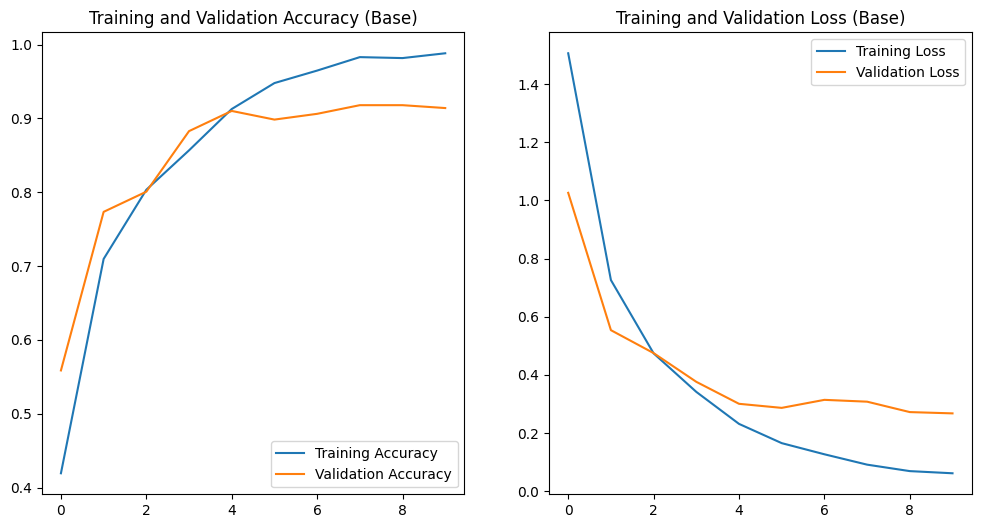

In [ ]:
plot_accuracy_loss(history_base)

In [ ]:
y_true, y_pred = eval_model_on_test(model_CNNbase, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 341ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:05,  1.40it/s]

1/1 [==============================] - 0s 284ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:03,  1.92it/s]

1/1 [==============================] - 0s 217ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:01<00:02,  2.00it/s]

1/1 [==============================] - 0s 222ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.86it/s]

1/1 [==============================] - 0s 254ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  1.78it/s]

1/1 [==============================] - 0s 168ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:01,  1.97it/s]

1/1 [==============================] - 0s 235ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.08it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


In [ ]:
print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of base model on test data: 89.88%
                       precision    recall  f1-score   support

clothes_0_model_front       0.77      0.90      0.83        51
     clothes_1_zoomed       0.92      1.00      0.96        58
 clothes_2_model_back       0.93      0.61      0.74        46
      clothes_3_ghost       0.98      0.95      0.96        43
       clothes_4_look       0.94      1.00      0.97        49

             accuracy                           0.90       247
            macro avg       0.91      0.89      0.89       247
         weighted avg       0.91      0.90      0.89       247



,0,1,2,3,4
0,46,1,2,1,1
1,0,58,0,0,0
2,14,3,28,0,1
3,0,1,0,41,1
4,0,0,0,0,49


## Transfer learning - ResNet50 without Tuning

In [ ]:
model_resnet_base = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [ ]:
for layer in model_resnet_base.layers[-5:]:
  print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [ ]:
# SHARED PARAMETER
# Number of classes
num_classes = 5

In [ ]:
# Sequential model creation:

# Make the base resnet model
# Points to last layer
last_conv_layer = model_resnet_base.get_layer('conv5_block3_out')
# Convolutional part from the resnet model
conv_model = Model(inputs=model_resnet_base.input, outputs=last_conv_layer.output)
# Freeze all conv layers
conv_model.trainable = False

In [ ]:
# Start a new Keras Sequential model
model_resnet = Sequential()

# Add a Lambda layer to apply preprocess_input of resnet model
model_resnet.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))

# Add the convolutional part of the model from above
model_resnet.add(conv_model)

# The resnet model uses a global average pooling layer before the final dense layer
# other models may just flatten the final convolutional layer or
# use other pooling layers so make sure to check the original model architecture
model_resnet.add(tf.keras.layers.GlobalAveragePooling2D())

# TODO try additional dense layer with 256 nodes
# TODO try dropout with 0.2 rate

# Add a final dense (aka. fully-connected) layer
# This is for combining features recognized in the image and calculating predictions
# note that the number of nodes is the same as the number of classes
model_resnet.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
for layer in model_resnet_base.layers:
    print(layer.name, '->', layer.trainable)

input_1 -> False
conv1_pad -> False
conv1_conv -> False
conv1_bn -> False
conv1_relu -> False
pool1_pad -> False
pool1_pool -> False
conv2_block1_1_conv -> False
conv2_block1_1_bn -> False
conv2_block1_1_relu -> False
conv2_block1_2_conv -> False
conv2_block1_2_bn -> False
conv2_block1_2_relu -> False
conv2_block1_0_conv -> False
conv2_block1_3_conv -> False
conv2_block1_0_bn -> False
conv2_block1_3_bn -> False
conv2_block1_add -> False
conv2_block1_out -> False
conv2_block2_1_conv -> False
conv2_block2_1_bn -> False
conv2_block2_1_relu -> False
conv2_block2_2_conv -> False
conv2_block2_2_bn -> False
conv2_block2_2_relu -> False
conv2_block2_3_conv -> False
conv2_block2_3_bn -> False
conv2_block2_add -> False
conv2_block2_out -> False
conv2_block3_1_conv -> False
conv2_block3_1_bn -> False
conv2_block3_1_relu -> False
conv2_block3_2_conv -> False
conv2_block3_2_bn -> False
conv2_block3_2_relu -> False
conv2_block3_3_conv -> False
conv2_block3_3_bn -> False
conv2_block3_add -> False
con

In [ ]:
# SHARED PARAMETERS
# Optimizer, learning rate, loss and metrics
learning_rate = 1e-5
optimizer = Adam(learning_rate=learning_rate) # TODO try SGD with Momentum and dynamic learning rate
loss = 'sparse_categorical_crossentropy'
metrics_monitor = ['accuracy']

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

# Default number of epochs
epochs = 40

In [ ]:
model_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

history_resnet = model_resnet.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 19s 447ms/step - loss: 1.7327 - accuracy: 0.2161 - val_loss: 1.6545 - val_accuracy: 0.2422
Epoch 2/40
24/24 [==============================] - 9s 381ms/step - loss: 1.6841 - accuracy: 0.2370 - val_loss: 1.6142 - val_accuracy: 0.2539
Epoch 3/40
24/24 [==============================] - 10s 402ms/step - loss: 1.6414 - accuracy: 0.2396 - val_loss: 1.5784 - val_accuracy: 0.2695
Epoch 4/40
24/24 [==============================] - 9s 395ms/step - loss: 1.6031 - accuracy: 0.2669 - val_loss: 1.5460 - val_accuracy: 0.2891
Epoch 5/40
24/24 [==============================] - 9s 395ms/step - loss: 1.5682 - accuracy: 0.2930 - val_loss: 1.5162 - val_accuracy: 0.3047
Epoch 6/40
24/24 [==============================] - 9s 388ms/step - loss: 1.5361 - accuracy: 0.3164 - val_loss: 1.4884 - val_accuracy: 0.3438
Epoch 7/40
24/24 [==============================] - 9s 382ms/step - loss: 1.5061 - accuracy: 0.3346 - val_loss: 1.4621 - val_accuracy: 0.3594
Epoc

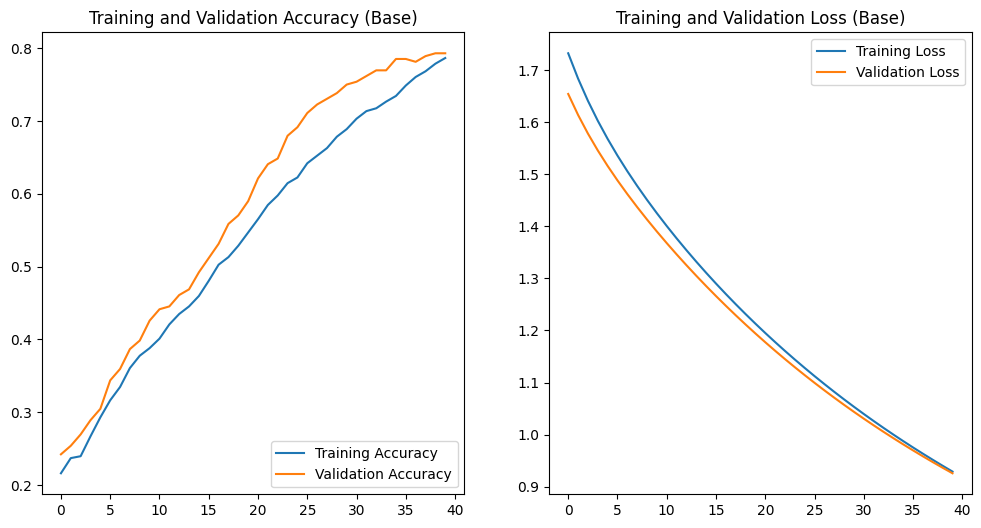

In [ ]:
plot_accuracy_loss(history_resnet)

In [ ]:
y_true, y_pred = eval_model_on_test(model_resnet, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:02<00:14,  2.01s/it]

1/1 [==============================] - 0s 106ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:02<00:06,  1.07s/it]

1/1 [==============================] - 0s 127ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

1/1 [==============================] - 0s 107ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:03<00:02,  1.56it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  1.85it/s]

1/1 [==============================] - 0s 76ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:04<00:00,  2.08it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:04<00:00,  2.26it/s]

1/1 [==============================] - 5s 5s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


In [ ]:
print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of base model on test data: 76.52%
                       precision    recall  f1-score   support

clothes_0_model_front       0.61      0.73      0.66        51
     clothes_1_zoomed       0.89      0.88      0.89        58
 clothes_2_model_back       0.59      0.57      0.58        46
      clothes_3_ghost       0.88      0.84      0.86        43
       clothes_4_look       0.89      0.80      0.84        49

             accuracy                           0.77       247
            macro avg       0.77      0.76      0.76       247
         weighted avg       0.77      0.77      0.77       247



,0,1,2,3,4
0,37,0,9,0,5
1,3,51,0,4,0
2,17,2,26,1,0
3,0,4,3,36,0
4,4,0,6,0,39


## ResNet Fine-Tuning: Unlocking layers for training

In [ ]:
# if use sequential model creation:
conv_model.trainable = True
for layer in conv_model.layers:
# if use functional model creation:
#model_resnet_base.trainable = True
#for layer in model_resnet_base.layers:
    if('conv5' not in layer.name):
        layer.trainable = False
    if('bn' in layer.name):
        layer.trainable = False
    print(layer.name, layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [ ]:
model_resnet_ft = Sequential()
model_resnet_ft.add(layers.Lambda(tf.keras.applications.resnet.preprocess_input, input_shape=IMG_SHAPE))
model_resnet_ft.add(conv_model)
model_resnet_ft.add(tf.keras.layers.GlobalAveragePooling2D())
# TODO try additional dense layer with 256 nodes
# TODO try dropout with 0.2 rate
model_resnet_ft.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model_resnet_ft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 427, 350, 3)       0         
                                                                 
 model (Functional)          (None, 14, 11, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 14963717 (57.08 MB)
Non-trainable params: 8634240 (32.94 MB)
_________________________________________________________________


In [ ]:
#model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

# If the following error occurs when calling the fit() method, run these lines of code instead:
#KeyError: 'The optimizer cannot recognize variable conv5_block1_1_conv/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately.
#Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'
# Get the list of trainable variables
#trainable_vars = model_resnet_ft.trainable_variables

# Manually build the optimizer with the list of trainable variables
#model_resnet_ft.optimizer.build(trainable_vars)

# If it doesn't help:
from tensorflow.keras.optimizers.legacy import Adam as Adam_l
optimizer = Adam_l(learning_rate=learning_rate)
model_resnet_ft.compile(optimizer=optimizer, loss=loss, metrics=metrics_monitor)

In [ ]:
history_resnet_ft = model_resnet_ft.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        callbacks = [early_stopping_cb]
                        )

Epoch 1/40
24/24 [==============================] - 24s 533ms/step - loss: 1.3900 - accuracy: 0.4349 - val_loss: 0.9460 - val_accuracy: 0.6875
Epoch 2/40
24/24 [==============================] - 11s 485ms/step - loss: 0.5524 - accuracy: 0.8568 - val_loss: 0.2854 - val_accuracy: 0.9453
Epoch 3/40
24/24 [==============================] - 11s 479ms/step - loss: 0.1619 - accuracy: 0.9583 - val_loss: 0.1459 - val_accuracy: 0.9531
Epoch 4/40
24/24 [==============================] - 11s 468ms/step - loss: 0.0688 - accuracy: 0.9792 - val_loss: 0.1078 - val_accuracy: 0.9844
Epoch 5/40
24/24 [==============================] - 11s 473ms/step - loss: 0.0355 - accuracy: 0.9935 - val_loss: 0.1079 - val_accuracy: 0.9766
Epoch 6/40
24/24 [==============================] - 11s 479ms/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 0.1150 - val_accuracy: 0.9609
Epoch 7/40
24/24 [==============================] - 11s 471ms/step - loss: 0.0168 - accuracy: 0.9974 - val_loss: 0.0956 - val_accuracy: 0.9805

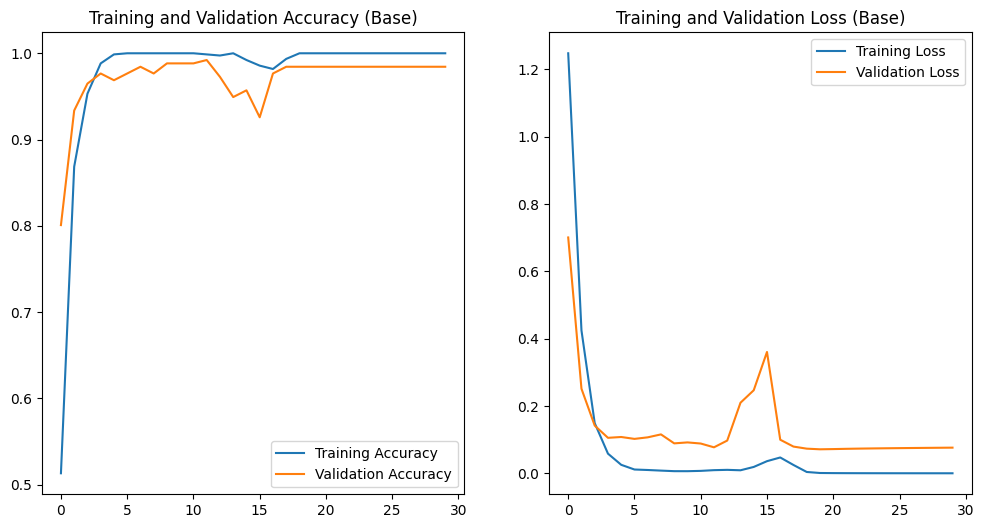

In [ ]:
plot_accuracy_loss(history_resnet_ft)

In [ ]:
y_true, y_pred = eval_model_on_test(model_resnet_ft, test_ds)

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:12,  1.76s/it]

1/1 [==============================] - 0s 136ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:02<00:05,  1.01it/s]

1/1 [==============================] - 0s 124ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.36it/s]

1/1 [==============================] - 0s 98ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:03<00:02,  1.64it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  1.92it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.14it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:04<00:00,  2.30it/s]

1/1 [==============================] - 5s 5s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


In [ ]:
print("Accuracy of base model on test data: %.2f%%" % (accuracy_score(y_true, y_pred)*100))
print(classification_report(y_true, y_pred, target_names=CLASSES))
pd.DataFrame(confusion_matrix(y_true, y_pred))

Accuracy of base model on test data: 97.17%
                       precision    recall  f1-score   support

clothes_0_model_front       0.93      0.98      0.95        51
     clothes_1_zoomed       0.98      0.97      0.97        58
 clothes_2_model_back       0.98      0.96      0.97        46
      clothes_3_ghost       1.00      1.00      1.00        43
       clothes_4_look       0.98      0.96      0.97        49

             accuracy                           0.97       247
            macro avg       0.97      0.97      0.97       247
         weighted avg       0.97      0.97      0.97       247



,0,1,2,3,4
0,50,0,0,0,1
1,1,56,1,0,0
2,1,1,44,0,0
3,0,0,0,43,0
4,2,0,0,0,47


In [ ]:
#model_resnet_ft.save('clothes_model_resnet_ft.keras')

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_model_resnet_ft.keras", save_best_only=True)

history_base = model_resnet_ft.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=epochs,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds)

Epoch 1/40
24/24 [==============================] - 13s 537ms/step - loss: 6.9837e-04 - accuracy: 1.0000 - val_loss: 0.0721 - val_accuracy: 0.9844
Epoch 2/40
24/24 [==============================] - 12s 501ms/step - loss: 5.0798e-04 - accuracy: 1.0000 - val_loss: 0.0729 - val_accuracy: 0.9844
Epoch 3/40
24/24 [==============================] - 12s 495ms/step - loss: 3.8345e-04 - accuracy: 1.0000 - val_loss: 0.0737 - val_accuracy: 0.9844
Epoch 4/40
24/24 [==============================] - 12s 487ms/step - loss: 3.0567e-04 - accuracy: 1.0000 - val_loss: 0.0743 - val_accuracy: 0.9844
Epoch 5/40
24/24 [==============================] - 11s 475ms/step - loss: 2.5299e-04 - accuracy: 1.0000 - val_loss: 0.0748 - val_accuracy: 0.9844
Epoch 6/40
24/24 [==============================] - 12s 482ms/step - loss: 2.1488e-04 - accuracy: 1.0000 - val_loss: 0.0753 - val_accuracy: 0.9844


In [ ]:
model_resnet_ft.save('clothes_model_resnet_ft.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Get mismatches



In [ ]:
def get_mismatches():
  num_mismatches = 0
  mismatch_tensor_indexes = {}
  for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
      num_mismatches += 1
      key = ((i+1)//BATCH_SIZE)
      tensor_index = (i % BATCH_SIZE)
      if mismatch_tensor_indexes.get(key) is not None:
        mismatch_tensor_indexes[key].append((tensor_index, i))
      else:
        mismatch_tensor_indexes[key] = [(tensor_index, i)]
  return num_mismatches, mismatch_tensor_indexes

In [ ]:
num_mismatches, mismatch_tensor_indexes = get_mismatches()
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 7


{3: [(29, 125)],
 4: [(28, 156)],
 5: [(0, 160), (15, 175)],
 6: [(21, 213), (24, 216)],
 7: [(17, 241)]}

In [ ]:
print(f'Test data image count = {len(y_true)}\n') # Returned from eval_model_on_test(model_base, test_ds) function

i=0
for images, labels in test_ds.take(8):
  print(i, len(labels))
  print(labels)
  i += 1

# With 247 images in test and batch size of 32, the last tensor labels should only have 23 labels (i.e. 7*32 + 23 = 247)
# Why do we have 32 labels in the last Tensor??? That would mean we have 8*32 = 256 images which is not the case!!!

Test data image count = 247

0 32
tf.Tensor([4 0 3 1 4 1 0 1 4 1 1 2 2 4 4 4 1 3 1 2 0 1 0 0 4 0 2 4 4 2 3 0], shape=(32,), dtype=int32)
1 32
tf.Tensor([2 4 2 3 0 4 1 1 3 0 2 4 3 1 1 0 2 1 3 3 4 1 2 3 1 2 3 4 2 1 4 0], shape=(32,), dtype=int32)
2 32
tf.Tensor([1 3 0 0 0 2 2 4 3 2 4 4 0 1 0 3 0 4 0 0 4 0 0 2 3 0 4 1 1 2 2 1], shape=(32,), dtype=int32)
3 32
tf.Tensor([3 4 1 1 0 1 2 2 2 3 0 0 1 2 2 2 0 0 1 3 4 1 1 3 4 4 0 3 2 4 3 0], shape=(32,), dtype=int32)
4 32
tf.Tensor([2 0 2 3 4 3 1 0 4 2 4 4 2 1 0 1 0 0 1 2 4 0 4 4 3 1 2 1 1 1 0 2], shape=(32,), dtype=int32)
5 32
tf.Tensor([1 2 0 1 1 2 3 1 2 0 3 1 4 2 0 0 0 2 1 2 3 3 4 0 1 4 3 0 4 2 1 4], shape=(32,), dtype=int32)
6 32
tf.Tensor([1 2 4 4 4 1 1 3 4 1 2 1 0 3 2 3 4 1 4 1 2 2 0 3 4 3 1 1 1 4 1 3], shape=(32,), dtype=int32)
7 23
tf.Tensor([4 4 3 4 3 0 0 1 3 3 0 3 3 2 3 1 3 2 0 3 0 0 1], shape=(23,), dtype=int32)


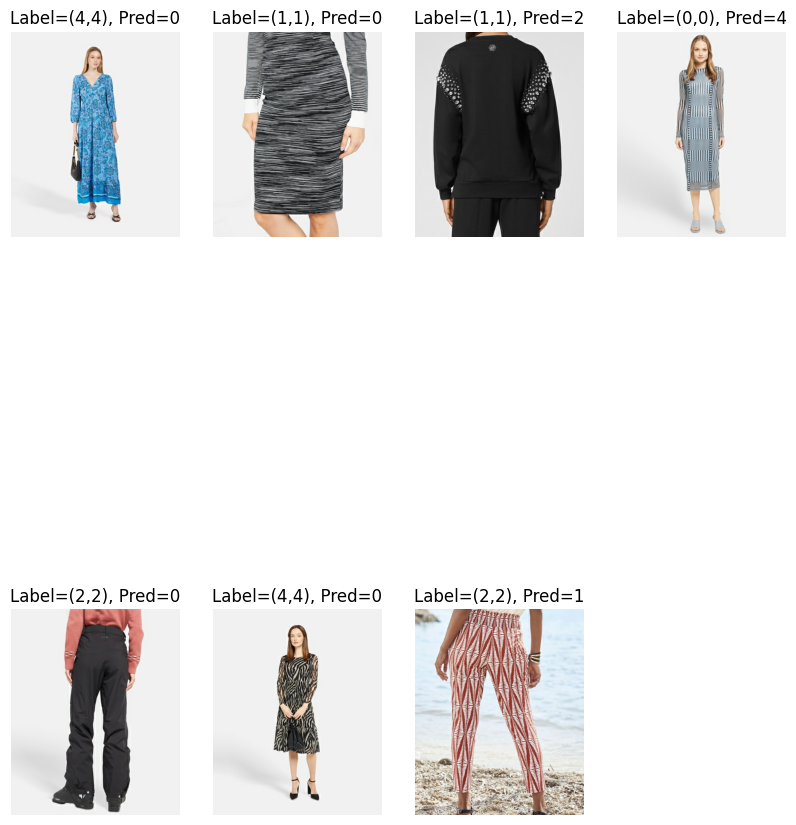

In [ ]:
import math
i=0
total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
tensor_batch = 0
plt.figure(figsize=(10, 15))
for images, labels in test_ds.take(total_tensor_batches):
  if mismatch_tensor_indexes.get(tensor_batch) is not None:
    for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
      ax = plt.subplot(math.ceil(num_mismatches/4), 4, i+1)
      plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
      plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
      plt.axis("off")
      i += 1
  tensor_batch += 1

plt.show()


In [ ]:
import math
i=0
total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
plt.figure(figsize=(15, 200))
for images, labels in test_ds.take(total_tensor_batches):
  for j in range(len(labels)):
    # print(f'{i}, {j}')
    ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
    plt.imshow(images[j].numpy().astype("uint8"))
    plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
    plt.axis("off")
    i += 1

Output hidden; open in https://colab.research.google.com to view.